# Path of Steepest Ascent

The **path of steepest ascent** represents the direction of maximum increase in the response. On a contour plot, this path runs **perpendicular to the contour lines**.

This notebook demonstrates how to calculate and visualize the path of steepest ascent for:
1. **First-order models** (without interactions)
2. **2FI models** (with two-factor interactions)

## Setup

Import required libraries and configure display options.

In [157]:
### Setup ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Set pandas to display floating-point numbers with 3 decimal places for cleaner output
pd.set_option("display.precision", 3)

## Helper Functions

We define three helper functions:
1. `contour_plot`: Create contour plots of the response surface
2. `build_steepest_ascent_path`: Calculate path for first-order models (no interactions)
3. `build_steepest_ascent_path_2fi`: Calculate path for models with 2-factor interactions

In [158]:
# Helper function to create contour plots

def contour_plot(fit, x1_range, x2_range, x1_label, x2_label, title, x1_var='x1', x2_var='x2', fixed_vars=None, show=True):
    """
    Create a contour plot of the fitted response surface.
    
    Parameters:
    -----------
    fit : statsmodels results object
        Fitted regression model
    x1_range : tuple
        Range for x1 axis (min, max)
    x2_range : tuple
        Range for x2 axis (min, max)
    x1_label : str
        Label for x1 axis
    x2_label : str
        Label for x2 axis
    title : str
        Plot title
    x1_var : str
        Name of x1 variable in the model
    x2_var : str
        Name of x2 variable in the model
    fixed_vars : dict
        Dictionary of variables to hold constant (for models with >2 factors)
    show : bool
        Whether to display the plot immediately
    """
    x1_vals = np.linspace(x1_range[0], x1_range[1], 100)
    x2_vals = np.linspace(x2_range[0], x2_range[1], 100)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)
    grid = pd.DataFrame({x1_var: X1.ravel(), x2_var: X2.ravel()})

    # Add any fixed variables (e.g., if more than 2 predictors are present)
    if fixed_vars is not None:
        for var, value in fixed_vars.items():
            grid[var] = value

    Z = fit.predict(grid).to_numpy().reshape(X1.shape)

    plt.figure(figsize=(8, 6))
    contour = plt.contour(X1, X2, Z, levels=20, cmap='viridis')
    plt.clabel(contour, inline=True, fontsize=8)
    plt.xlabel(x1_label)
    plt.ylabel(x2_label)
    plt.title(title)
    plt.grid()
    if show == True:
        plt.show()

In [159]:
# Helper function to build path of steepest ascent (first-order models)

def build_steepest_ascent_path(fit, start, reference_var='x1', step_size=0.1, n_steps=10):
    """
    Build path of steepest ascent for first-order models (no interactions).
    
    The path is constant because the gradient doesn't change across the design space.
    
    Parameters:
    -----------
    fit : statsmodels results object
        Fitted first-order regression model
    start : dict
        Starting point for each variable (coded units)
    reference_var : str
        Variable to use as reference for step size
    step_size : float
        Step size for the reference variable (coded units)
    n_steps : int
        Number of steps to take along the path
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns for step number and each variable's value
    """
    params = fit.params
    b_ref = float(params[reference_var])
    delta_ref = np.sign(b_ref) * abs(step_size)  # choose sign to go uphill

    deltas = {k: (delta_ref if k == reference_var else float(params[k]) / b_ref * delta_ref)
              for k in start.keys()}

    rows = []
    for t in range(n_steps + 1):
        row = {'step': t}
        for k in start.keys():
            row[k] = start[k] + t * deltas[k]
        rows.append(row)
    return pd.DataFrame(rows)

In [160]:
# Helper function to build path of steepest ascent with interaction terms (2FI)

def build_steepest_ascent_path_2fi(fit, start, reference_var='x1', step_size=0.1, n_steps=10):
    """
    Build path of steepest ascent for models with 2-factor interactions.
    Recalculates local slopes at each step to account for interactions.
    
    With interactions, the gradient changes across the design space, so we must
    recalculate the local slopes at each point along the path.

    Parameters:
    -----------
    fit : statsmodels results object
        Fitted regression model with interaction terms
    start : dict
        Starting point for each variable (coded units)
    reference_var : str
        Variable to use as reference for step size
    step_size : float
        Step size for the reference variable (coded units)
    n_steps : int
        Number of steps to take along the path

    Returns:
    --------
    pd.DataFrame
        DataFrame with columns for step number and each variable's value
    """
    params = fit.params
    rows = []
    current = start.copy()

    for t in range(n_steps + 1):
        # Record current position
        row = {'step': t}
        row.update(current)
        rows.append(row)

        if t < n_steps:  # Don't calculate next step after the last one
            # Calculate local slopes at current position
            local_slopes = {}

            for var in start.keys():
                # Start with main effect coefficient
                slope = float(params.get(var, 0.0))

                # Add interaction effects
                for other_var in start.keys():
                    if other_var != var:
                        # Check for interaction term in both orders
                        interaction_term = f'{var}:{other_var}'
                        interaction_term_rev = f'{other_var}:{var}'

                        if interaction_term in params.index:
                            slope += float(params[interaction_term]) * current[other_var]
                        elif interaction_term_rev in params.index:
                            slope += float(params[interaction_term_rev]) * current[other_var]

                local_slopes[var] = slope

            # Calculate step for reference variable (with sign to go uphill)
            delta_ref = np.sign(local_slopes[reference_var]) * abs(step_size)

            # Calculate relative steps for other variables
            deltas = {}
            for var in start.keys():
                if var == reference_var:
                    deltas[var] = delta_ref
                else:
                    deltas[var] = (local_slopes[var] / local_slopes[reference_var]) * delta_ref

            # Update current position
            for var in start.keys():
                current[var] += deltas[var]

    return pd.DataFrame(rows)

---

## Example 1: Plasma Etching (First-Order Model)

This example demonstrates the path of steepest ascent for a **first-order model without interactions**.

### Model Form

$$\hat{y} = b_0 + b_1 x_1 + b_2 x_2$$

For first-order models, the gradient is **constant** across the entire design space, so the path of steepest ascent is a straight line.

### Method

1. Fit a first-order model to the data
2. Extract coefficients $(b_1, b_2)$ which define the gradient
3. Choose a reference variable and step size $\Delta x_j$
4. Calculate relative steps: $\Delta x_k = \frac{b_k}{b_j}\,\Delta x_j$

### Load and Explore Data

In [161]:
# Load the plasma etching dataset
plasma = pd.read_csv("plasma.csv")
plasma

,gap,power,x1,x2,etch
0,1.2,275,-1,-1,775
1,1.6,275,1,-1,670
2,1.2,325,-1,1,890
3,1.6,325,1,1,730
4,1.4,300,0,0,745
5,1.4,300,0,0,760
6,1.4,300,0,0,780
7,1.4,300,0,0,720


### Fit the Model

In [162]:
# Fit a first-order linear regression model
fit_plasma = smf.ols("etch ~ x1 + x2", data=plasma).fit()
print(fit_plasma.summary())

                            OLS Regression Results                            
Dep. Variable:                   etch   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     20.17
Date:                Sat, 01 Nov 2025   Prob (F-statistic):            0.00404
Time:                        23:29:20   Log-Likelihood:                -35.223
No. Observations:                   8   AIC:                             76.45
Df Residuals:                       5   BIC:                             76.68
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    758.7500      8.839     85.843      0.0

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  res = hypotest_fun_out(*samples, **kwds)


### Visualize the Response Surface

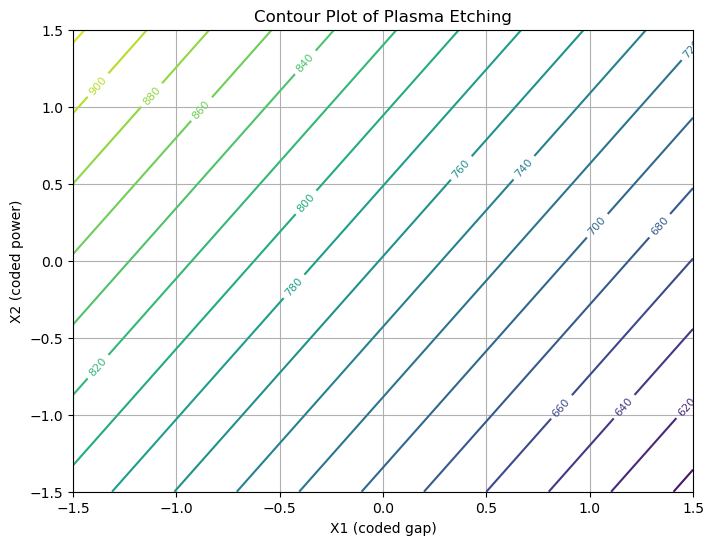

In [163]:
# Create a contour plot of the fitted surface
contour_plot(fit_plasma, x1_range=(-1.5, 1.5), x2_range=(-1.5, 1.5),
             x1_label="X1 (coded gap)", x2_label="X2 (coded power)",
             title="Contour Plot of Plasma Etching")

### Calculate the Direction of Steepest Ascent

The direction is determined by the ratio of coefficients. We choose x1 as the reference variable.

In [164]:
reference_var = 'x1'  # Choose x1 as reference variable
step_size = 1         # Magnitude (coded units) for the reference variable

# Get the coefficient and determine direction (sign)
b_ref = fit_plasma.params[reference_var]
step = np.sign(b_ref) * step_size

# Calculate the change in x2 using the ratio rule
delta_x2 = (fit_plasma.params['x2'] / fit_plasma.params['x1']) * step

print(f"Coefficients:")
print(f"  b_x1 = {fit_plasma.params['x1']:.4f}")
print(f"  b_x2 = {fit_plasma.params['x2']:.4f}")
print()
print(f"Direction of steepest ascent:")
print(f"  When x1 changes by {step_size} (coded units),")
print(f"  x2 should change by {delta_x2:.4f} to move along the path of steepest ascent.")

Coefficients:
  b_x1 = -66.2500
  b_x2 = 43.7500

Direction of steepest ascent:
  When x1 changes by 1 (coded units),
  x2 should change by 0.6604 to move along the path of steepest ascent.


### Build the Complete Path

Now we use the helper function to generate multiple points along the path.

In [165]:
# Build the path starting from the design center
path = build_steepest_ascent_path(
    fit=fit_plasma,
    start={'x1': 0.0, 'x2': 0.0},
    reference_var='x1',
    step_size=1,
    n_steps=4
)
path

,step,x1,x2
0,0,0.0,0.000
1,1,-1.0,0.660
2,2,-2.0,1.321
3,3,-3.0,1.981
4,4,-4.0,2.642


### Overlay Path on Contour Plot

The path should be perpendicular to the contour lines.

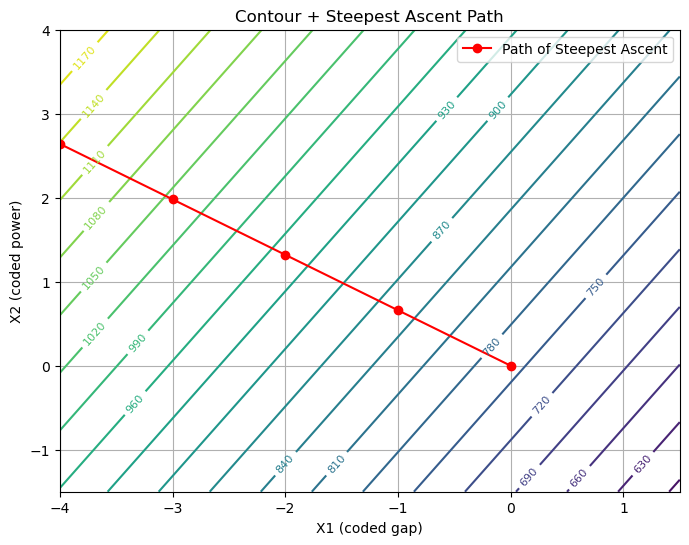

In [166]:
# Create contour plot and overlay the path
contour_plot(fit_plasma, x1_range=(-4, 1.5), x2_range=(-1.5, 4),
             x1_label="X1 (coded gap)", x2_label="X2 (coded power)",
             title="Contour + Steepest Ascent Path", show=False)
plt.plot(path['x1'], path['x2'], marker='o', color='red', label='Path of Steepest Ascent')
plt.legend()
plt.show()

---

## Example 2: Filtration Rate (Model with 2FI Interactions)

This example demonstrates the path of steepest ascent for a **model with two-factor interactions (2FI)**.

### Model Form

$$\hat{y} = b_0 + \sum b_i x_i + \sum_{i<j} b_{ij} x_i x_j$$

With interactions, the gradient **changes** across the design space. The local slope for each variable depends on the current levels of other variables:

$$s_k = b_k + \sum_{i \neq k} b_{ki}\, x_{c,i}$$

### Method

1. Fit a 2FI model to the data
2. At the current point $x_c$, compute local slopes $s_k$
3. Choose a reference variable and step size $\Delta x_j$
4. Calculate relative steps: $\Delta x_k = \frac{s_k}{s_j}\,\Delta x_j$
5. **Recalculate** local slopes at each new point along the path

### Load and Explore Data

In [167]:
# Load the filtration dataset
filtration = pd.read_csv("filtration.csv")
filtration

,T,P,CoF,RPM,Filtration_rate
0,-1,-1,-1,-1,45
1,1,-1,-1,-1,71
2,-1,1,-1,-1,48
3,1,1,-1,-1,65
4,-1,-1,1,-1,68
5,1,-1,1,-1,60
6,-1,1,1,-1,80
7,1,1,1,-1,65
8,-1,-1,-1,1,43
9,1,-1,-1,1,100


### Fit the Model with Interactions

In [168]:
# Fit a model with main effects and two-factor interactions
fit_filtration = smf.ols(
    "Filtration_rate ~ T + RPM + CoF + T:RPM + T:CoF", data=filtration).fit()
print(fit_filtration.summary())

                            OLS Regression Results                            
Dep. Variable:        Filtration_rate   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     56.74
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           5.14e-07
Time:                        23:29:21   Log-Likelihood:                -42.711
No. Observations:                  16   AIC:                             97.42
Df Residuals:                      10   BIC:                             102.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.0625      1.104     63.444      0.0

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


### Visualize the Response Surface

Since we have 3 factors, we create a 2D contour plot by holding CoF constant at 0.

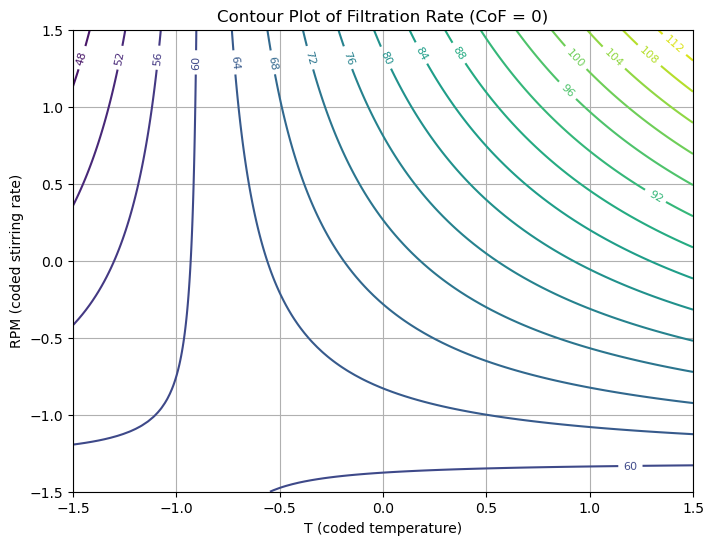

In [169]:
# Contour plot - hold CoF at its center value (0 for coded variables)
contour_plot(fit_filtration, x1_range=(-1.5, 1.5), x2_range=(-1.5, 1.5),
             x1_label="T (coded temperature)", x2_label="RPM (coded stirring rate)",
             title="Contour Plot of Filtration Rate (CoF = 0)",
             x1_var='T', x2_var='RPM', fixed_vars={'CoF': 0.0})

### Example: Computing Local Slopes at a Specific Point

Let's manually calculate the local slopes at $T = 0.5$, $RPM = 0.5$, $CoF = 0.0$ to understand how interactions affect the gradient.

In [170]:
# Extract coefficients
b_T = fit_filtration.params['T']
b_RPM = fit_filtration.params['RPM']
b_CoF = fit_filtration.params['CoF']
b_T_RPM = fit_filtration.params['T:RPM']
b_T_CoF = fit_filtration.params['T:CoF']

# Current position
x_T = 0.5
x_RPM = 0.5
x_CoF = 0.0

# Calculate local slopes
s_T = b_T + b_T_RPM * x_RPM + b_T_CoF * x_CoF
s_RPM = b_RPM + b_T_RPM * x_T
s_CoF = b_CoF + b_T_CoF * x_T

print("Model coefficients:")
print(f"  b_T = {b_T:.4f}")
print(f"  b_RPM = {b_RPM:.4f}")
print(f"  b_CoF = {b_CoF:.4f}")
print(f"  b_T:RPM = {b_T_RPM:.4f}")
print(f"  b_T:CoF = {b_T_CoF:.4f}")
print()
print(f"Local slopes at T={x_T}, RPM={x_RPM}, CoF={x_CoF}:")
print(f"  s_T = {b_T:.4f} + {b_T_RPM:.4f}×{x_RPM} + {b_T_CoF:.4f}×{x_CoF} = {s_T:.4f}")
print(f"  s_RPM = {b_RPM:.4f} + {b_T_RPM:.4f}×{x_T} = {s_RPM:.4f}")
print(f"  s_CoF = {b_CoF:.4f} + {b_T_CoF:.4f}×{x_T} = {s_CoF:.4f}")
print()

# Using T as reference with step size 0.1
step_size = 0.1
delta_RPM = (s_RPM / s_T) * step_size
delta_CoF = (s_CoF / s_T) * step_size

print(f"Direction at this point (using T as reference with ΔT = {step_size}):")
print(f"  ΔRPM = ({s_RPM:.4f}/{s_T:.4f}) × {step_size} = {delta_RPM:.4f}")
print(f"  ΔCoF = ({s_CoF:.4f}/{s_T:.4f}) × {step_size} = {delta_CoF:.4f}")

Model coefficients:
  b_T = 10.8125
  b_RPM = 7.3125
  b_CoF = 4.9375
  b_T:RPM = 8.3125
  b_T:CoF = -9.0625

Local slopes at T=0.5, RPM=0.5, CoF=0.0:
  s_T = 10.8125 + 8.3125×0.5 + -9.0625×0.0 = 14.9688
  s_RPM = 7.3125 + 8.3125×0.5 = 11.4688
  s_CoF = 4.9375 + -9.0625×0.5 = 0.4062

Direction at this point (using T as reference with ΔT = 0.1):
  ΔRPM = (11.4688/14.9688) × 0.1 = 0.0766
  ΔCoF = (0.4062/14.9688) × 0.1 = 0.0027


### Build Paths from Different Starting Points

We'll create two paths to show how interactions cause the path to curve:
1. From the example point (T=0.5, RPM=0.5, CoF=0.0)
2. From the design center (T=0.0, RPM=0.0, CoF=0.0)

In [171]:
# Path 1: Starting from the example point
path_filtration = build_steepest_ascent_path_2fi(
    fit=fit_filtration,
    start={'T': 0.5, 'RPM': 0.5, 'CoF': 0.0},
    reference_var='T',
    step_size=0.1,
    n_steps=20
)
print("Path from T=0.5, RPM=0.5, CoF=0.0:")
print(path_filtration.head(10))

Path from T=0.5, RPM=0.5, CoF=0.0:
   step    T    RPM        CoF
0     0  0.5  0.500  0.000e+00
1     1  0.6  0.577  2.714e-03
2     2  0.7  0.656 -4.950e-04
3     3  0.8  0.736 -9.140e-03
4     4  0.9  0.818 -2.273e-02
5     5  1.0  0.901 -4.079e-02
6     6  1.1  0.985 -6.288e-02
7     7  1.2  1.069 -8.859e-02
8     8  1.3  1.153 -1.175e-01
9     9  1.4  1.238 -1.494e-01


In [172]:
# Path 2: Starting from the design center
path2_filtration = build_steepest_ascent_path_2fi(
    fit=fit_filtration,
    start={'T': 0.0, 'RPM': 0.0, 'CoF': 0.0},
    reference_var='T',
    step_size=0.1,
    n_steps=25
)
print("\nPath from design center (T=0, RPM=0, CoF=0):")
print(path2_filtration.head(10))


Path from design center (T=0, RPM=0, CoF=0):
   step    T    RPM    CoF
0     0  0.0  0.000  0.000
1     1  0.1  0.068  0.046
2     2  0.2  0.142  0.082
3     3  0.3  0.222  0.110
4     4  0.4  0.306  0.129
5     5  0.5  0.393  0.140
6     6  0.6  0.483  0.143
7     7  0.7  0.574  0.140
8     8  0.8  0.665  0.130
9     9  0.9  0.757  0.114


### Overlay Both Paths on Contour Plot

Notice how the paths **curve** due to the interaction effects. The direction changes as we move through the design space.

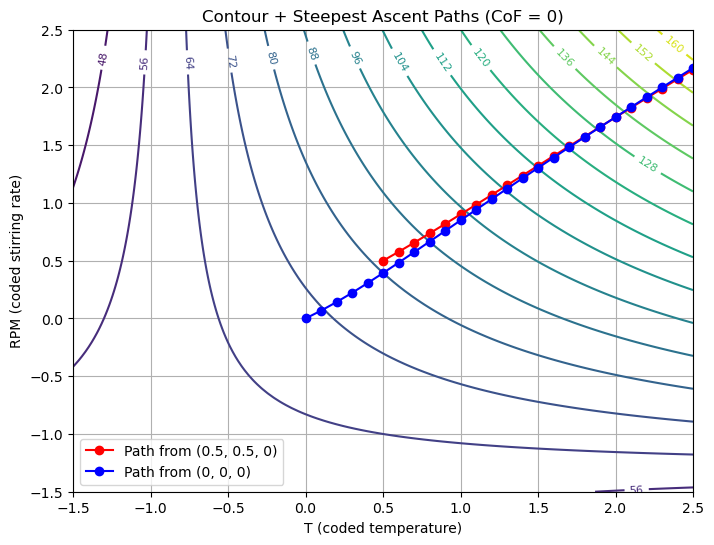

In [173]:
# Create contour plot and overlay both paths
contour_plot(fit_filtration, x1_range=(-1.5, 2.5), x2_range=(-1.5, 2.5),
             x1_label="T (coded temperature)", x2_label="RPM (coded stirring rate)",
             title="Contour + Steepest Ascent Paths (CoF = 0)",
             x1_var='T', x2_var='RPM', fixed_vars={'CoF': 0.0}, show=False)
plt.plot(path_filtration['T'], path_filtration['RPM'], marker='o',
         color='red', label='Path from (0.5, 0.5, 0)')
plt.plot(path2_filtration['T'], path2_filtration['RPM'], marker='o',
         color='blue', label='Path from (0, 0, 0)')
plt.legend()
plt.show()

---

## Key Takeaways

### First-Order Models (No Interactions)
- The gradient is **constant** across the design space
- The path of steepest ascent is a **straight line**
- Calculate once: $\Delta x_k = \frac{b_k}{b_j}\,\Delta x_j$

### Models with 2FI Interactions
- The gradient **changes** with position due to interactions
- The path of steepest ascent **curves**
- Must recalculate local slopes at each step: $s_k = b_k + \sum_{i \neq k} b_{ki}\, x_{c,i}$
- After several steps, consider refitting with a second-order model and using ridge analysis

### Practical Considerations
1. Use **coded units** for calculations
2. Start from the design center or current best point
3. Take small steps (e.g., 0.1 in coded units)
4. Monitor the response - stop when improvements level off
5. With interactions, periodically recalculate the direction